<a href="https://colab.research.google.com/github/dash-ka/Algorithms_for_massive_datasets/blob/master/SON_frequent_itemsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 55.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=37a3793eb4f13ce52655576abde3e5168647488e818a3374b0d8638ce1024c90
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Kaggle API
Upload a json file with your Kaggle API key.

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daryashlyk","key":"2b08cadfdfdf2a3eb5d27d5b55109d25"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

Download the dataset from Kaggle

In [4]:
!kaggle datasets download bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows -f UkraineCombinedTweetsDeduped20220227-131611.csv.gzip 
!unzip "/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip.zip" && rm *.zip
!rename "s/\.gzip/\.gz/" *

 98% 261M/266M [00:01<00:00, 176MB/s]
100% 266M/266M [00:01<00:00, 187MB/s]
Archive:  /content/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip.zip
  inflating: UkraineCombinedTweetsDeduped20220227-131611.csv.gzip  


##Tokenization

In [5]:
def tokenize(text):

  """
  Tokenize the tweet raw text using TweetTokenizer.
  Lower-case tokens and remove characters like @ and \#. 
  Filter out stopwords and keep strings made of alphabet characters only.

  Args:
    support: A tweet text.

  Returns:
     A list of words.

  """

  tokens = set()
  for x in tweet_tokenizer.tokenize(text):
    x = x.lstrip("[#@]").lower()
    if (x.isalpha()) and (x not in stop):
      tokens.add(x)
  return list(tokens)

## Savasare, Omiecinski and Navathe algorithm Implementation

In [6]:
def apriori(support):

    """
    Run A-priori algorithm over a partition of baskets
    to retrieve candidate frequent itemsets.

    Args:
      support: minimum support in percentage terms.

    Returns:
      A set of key-value pairs (tuple, 1),
      where tuple is a frequent itemset from the sample.

    """

    def search_local_candidates(partition):

      # read data
      baskets = []
      for v in partition:
        baskets.append(v)
          

      # compute adjusted threshold accounting for the partition size
      threshold = support * len(baskets) 
      w2i = {}

      # get frequent items
      Counter = defaultdict(lambda:0)
      for basket in baskets:
        for item in basket:
          if item not in w2i:
            w2i[item] = len(w2i.keys())
          Counter[w2i[item]]+=1
      i2w = {index:word for word, index in w2i.items()}
      freq_items = {i2w[idx] for idx, s in Counter.items() if s >= threshold}

      
      # initialize the output
      freq_sets = [] 
      k = 2

      # get frequent pairs
      Counter = defaultdict(lambda:0)
      for basket in baskets:
        pairs = combinations(filter(lambda x: x in freq_items, sorted(basket)), 2)
        for pair in pairs:
          pair = tuple(map(lambda token: w2i[token], pair))
          Counter[pair]+=1

      frequents = {tuple(map(lambda x :i2w[x], key)) for key, s in Counter.items() if s >= threshold}

      # get frequent itemsets of size > 2
      while len(frequents)!=0:
        k+=1 
        freq_sets.extend(frequents)
        previous_frequents = frequents
        Counter = defaultdict(lambda:0)
        for basket in baskets:
          if len(basket)>=k: # verify that the basket has at least k items
            candidates = combinations(filter(lambda x: x in freq_items, sorted(basket)), k)
            for candidate in candidates:
              subsets = set(combinations(filter(lambda x: x in freq_items, candidate), k-1))
              if len(subsets.intersection(set(previous_frequents)))==len(subsets):
                candidate = tuple(map(lambda token: w2i[token], candidate))
                Counter[candidate]+=1
                
        frequents = {tuple(map(lambda x :i2w[x], key)) for key, s in Counter.items() if s >= threshold}
          

      itemsets = list(map(lambda t:(t, 1), freq_sets))
      singleton = list(map(lambda t:((t,), 1), freq_items))
        
      return itemsets + singleton

    return search_local_candidates

In [7]:
def validate(candidates):

    """
    Invokes a function over a partition to
    compute the support of the candidate itemsets

    Args: 
    candidates: List of candidate itemsets
    
    Return:
    A set of key-value pairs (candidate_itemset, local_support),
    where candidate_itemset is a tuple of items.

    """

    def count_candidates(partition):
      baskets = []
      for v in partition:
        baskets.append(v)

      Counter = defaultdict(lambda:0)
      for basket in baskets:
        for candidate in candidates:
          if all(item in basket for item in candidate):
            Counter[candidate]+=1

      return Counter.items()
      
    return count_candidates 

In [8]:
def SON(data, min_support, n_baskets):

  """
    Implements the SON algorithm for finding frequent itemsets

    Args: 
    data: List of baskets
    support: Support threshold
    n_baskets: Total number of baskets to process
    
    Return:
    A sorted list of frequent itemsets and their support,
    formatted as tuples (frequent_itemset, support).

    """

  # PHASE_1: each partition generates a set of local candidates (frequent itemsets)
  candidates = (data.mapPartitions(apriori(min_support))
                  .groupByKey()
                  .map(lambda x:x[0])
                  .collect())
    
  # PHASE_2: counting global support for candidate itemsets
  frequent_itemsets = (sorted(data.mapPartitions(validate(candidates))
                    .reduceByKey(lambda x, y: x+y)
                    .filter(lambda x: x[1]>= min_support*n_baskets)
                    .map(lambda x: (list(x[0]), x[1]) )
                    .collect(), key=lambda x: -len(x[0])))
    
  return frequent_itemsets

## Mining frequent itemsets with SON algorithm

In [13]:
data = (spark.read.csv("/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gz",
                       header=True, multiLine = True, quote = "\"", escape="\"")
        .select("text","language")
        .where(F.col("language")=="en")
        .select("text").rdd
        .repartition(4)
        .map(lambda row: tokenize(row["text"]))
        .filter(lambda x:len(x)>1)
        .cache())

n_baskets = data.count()

In [10]:
n_baskets

722871

In [14]:
start = time.time()
son_result = SON(data, 0.1, n_baskets)
end = time.time()
print(end - start)
son_result

29.13709044456482


[(['russia', 'russian', 'ukraine'], 75580),
 (['russia', 'russian'], 82385),
 (['russia', 'ukraine'], 233309),
 (['russian', 'ukraine'], 157804),
 (['ukraine', 'war'], 79136),
 (['putin', 'ukraine'], 96320),
 (['people', 'ukraine'], 77476),
 (['ukraine', 'ukrainian'], 94407),
 (['russia'], 290464),
 (['russian'], 184662),
 (['ukraine'], 548232),
 (['war'], 101830),
 (['kyiv'], 91054),
 (['people'], 89893),
 (['ukrainian'], 110930),
 (['putin'], 137373)]

## Scale-up experiments

### Runtime of the SON algorithm with growing data size

In [15]:
size = np.arange(0.1, 0.71, step=0.1)

elapsed_time = dict()
for i in size:
  # extract a sample of baskets
  sample = data.sample(withReplacement=False, fraction= i , seed=3)
  n_sample = sample.count()

  # process the sample and record the execution time
  start = time.time()
  SON(sample, 0.15, n_sample) 
  end = time.time()
  elapsed_time[i] = end - start
  print(elapsed_time[i])

5.7286036014556885
7.02065896987915
8.853418827056885
10.498115539550781
11.699561595916748
13.245783805847168
14.504337072372437


### Runtime with different values of support threshold

In [16]:
threshold = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
support_time = dict()
for s in threshold:
  start = time.time()
  SON(data, s, n_baskets)  
  end = time.time()
  support_time[s] = end - start
  print(support_time[s])

60.83007264137268
34.34389662742615
27.942514657974243
21.75208806991577
17.830368518829346
17.116760730743408
16.094751358032227


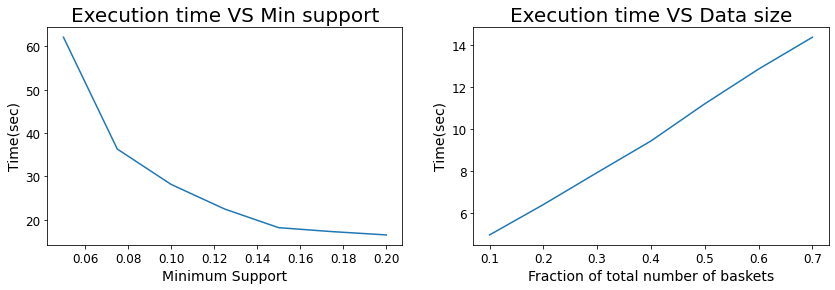

In [ ]:
fig, axes = plt.subplots(1, 2,figsize = (14,4))
axes[0].plot(list(support_time.keys()), list(support_time.values()))
axes[0].set_title("Execution time VS Min support", fontsize = 20)
axes[0].set_xlabel("Minimum Support", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylabel("Time(sec)", fontsize=14)

axes[1].plot(list(elapsed_time.keys()), list(elapsed_time.values()))
axes[1].set_title("Execution time VS Data size", fontsize = 20)
axes[1].set_xlabel("Fraction of total number of baskets", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_ylabel("Time(sec)", fontsize=14)
plt.savefig('scale.png')